# Feature Engineering

Outcome from EDA:
- Temperature-related variables
    - Show weak correlation with machine failure -> consider removing them or replacing with a new feature like 'Temp diff', which shows a slightly higher correlation.
    - Minor mean differences across different 'Type' -> if any temperature-related variable is kept, consider include 'Type' as feature to help capture those interactions.

- Torque
    - Shows moderate correlation with machine failure -> remain in feature list

- Rotational speed
    - Correlated with torque.
    - Interaction with torque appears helpful in predicting target -> retain its interaction with torque.

- Tool wear
    - No strong direct correlation with the target -> but worth keeping to contribute to the model since most features are weakly correlated anyway.

- Type
    - Statistical tests and visualizations suggest that 'Type' alone does not have a strong effect on the target.
    - However, it may influence the distribution of other variables like temperature → include 'Type' only if using features that vary by 'Type', such as temperature-related ones.

**Weak correlation does not imply the absence of a relationship between  variables as only linear relationship is measured by correlation coefficient. There may still be non-linear or interaction effect in between. Hence, feature selections need to be conducted to experiment the different combination of features**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef
from termcolor import cprint
import json

In [ ]:
df = pd.read_csv("../dataset/ai4i2020.csv")

In [71]:
pd.set_option('display.max_columns', None)
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


Created features:
- Temperatre difference = Process temperature [K] - Air temperature [K]
- rpm_torque = Rotational speed [rpm] * Torque [Nm]

In [72]:
df['Temp diff'] = df['Process temperature [K]'] - df['Air temperature [K]']
df['rpm_torque'] = df['Rotational speed [rpm]'] * df['Torque [Nm]']

In [73]:
df.rename(columns={'Air temperature [K]': 'Air temperature',
                   'Process temperature [K]': 'Process temperature',
                   'Rotational speed [rpm]': 'Rotational speed',
                   'Torque [Nm]': 'Torque',
                   'Tool wear [min]': 'Tool wear'
                   }, 
                   inplace=True)

In [74]:
# Encode 'Type' column into numerical
encoder = ce.OrdinalEncoder(cols=['Type'])
df = encoder.fit_transform(df)

In [ ]:
# Save processed data
df.to_csv("../dataset/processed_ai4i2020.csv")

### Baseline Model

Based on understanding from EDA, we will conduct feature and model selection using the set of given and created features, as well as the most basic decision tree model as baseline.

In [9]:
def preprocess(df, features):
    # Define input and target
    X = df[[feature for feature in features]]
    y = df['Machine failure']

    # Standardization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Spliting sample into 80-20 for training and testing
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

In [25]:
# baseline features
feature1 = ['Type', 
            'Air temperature', 'Process temperature', 'Temp diff',
            'Rotational speed', 'Torque', 'rpm_torque',
            'Tool wear']

In [26]:
X_train, X_test, y_train, y_test = preprocess(df, feature1)

# baseline model
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [27]:
# Get baseline performance
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
f1 = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

print(classification_report(y_test, y_pred), 
      "\nAccuracy: ", accuracy, 
      "\nROC_AUC score: ", roc_auc, 
      "\nF1-score: ", f1, 
      "\nMatthews correlation coefficient: ", mcc)


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1939
           1       0.70      0.77      0.73        61

    accuracy                           0.98      2000
   macro avg       0.85      0.88      0.86      2000
weighted avg       0.98      0.98      0.98      2000
 
Accuracy:  0.983 
ROC_AUC score:  0.880088604063274 
F1-score:  0.734375 
Matthews correlation coefficient:  0.7264660747578697


Due to **class-imbalanced** in the dataset, it is recommended to refer to the F1-score and Matthews correlation coefficient that take into account for FP and FN.

$$
F_1 = \frac{2 \cdot \text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}} 
\hspace{2cm}
\text{MCC} = \frac{TP \cdot TN - FP \cdot FN}{\sqrt{(TP + FP)(TP + FN)(TN + FP)(TN + FN)}}
$$

$$
\begin{array}{|c|l|}
\hline
\textbf{F1 Score} & \textbf{Performance Interpretation} \\
\hline
\geq 0.9 & \text{Great, with risk of overfitting} \\
0.7 \leq \text{F1} < 0.9 & \text{Good} \\
0.5 \leq \text{F1} < 0.7 & \text{Average} \\
< 0.5 & \text{Poor} \\
\hline
\end{array}
$$

$$
\begin{array}{|c|l|}
\hline
\textbf{MCC} & \textbf{Performance Interpretation} \\
\hline
+1 & \text{Perfect prediction} \\
0 & \text{No better than random guessing} \\
-1 & \text{Worst possible prediction} \\
\hline
\end{array}
$$



In [28]:
f1_baseline = f1
mcc_baseline = mcc
print(f"Baseline: \nF1-score: {f1_baseline:.4f} \nMatthews correlation coefficient: {mcc_baseline:.4f}")

Baseline: 
F1-score: 0.7344 
Matthews correlation coefficient: 0.7265


The F1-score of baseline model has just met the criteria of "good" range. We will continue with feature and model selection to improve the performance.

## Feature Selection

We would test on different set of features to see if we could create a new baseline that have better performance than the initial baseline.
Here, we will consider experience from EDA and feature importance given by the baseline model to remove feature that carries less importance step-by-step.

Surely, there are packages that help with feature selection such as Recursive Feature Elimination (RFE) from sklearn to do stepwise elimination, but we would try it the other time as there's some idea about feature selection from EDA process.

In [29]:
# Get feature importance
feature_importance = pd.Series(model.feature_importances_, index=feature1).sort_values(ascending=False)
print(feature_importance)

rpm_torque             0.376175
Temp diff              0.299351
Tool wear              0.126844
Rotational speed       0.092346
Torque                 0.030686
Type                   0.029046
Air temperature        0.026516
Process temperature    0.019035
dtype: float64


- From feature importance, the two created fearures 'rpm_torque' and 'Temp diff' takes a certain extend of weight.
- We can try to experiment on removal of 'Air temperature', 'Type' and 'Process temperature' as they seem to have lower importance.

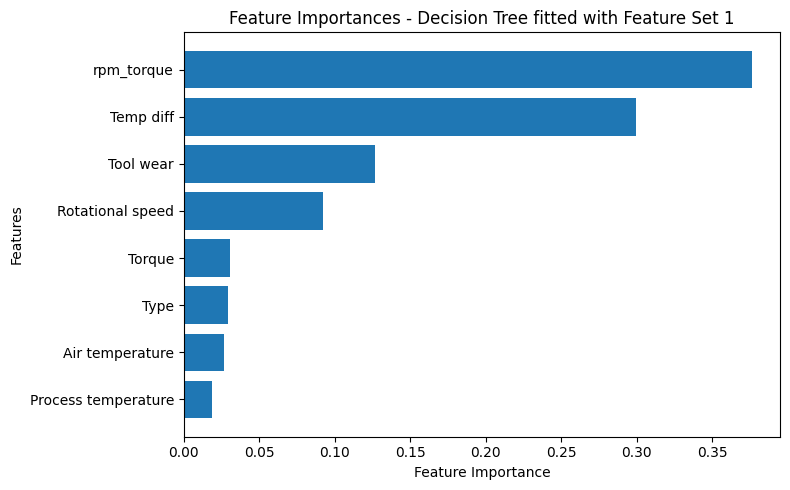

In [30]:
plt.figure(figsize=(8, 5))
plt.barh(range(len(feature_importance)), feature_importance, align='center')
plt.yticks(range(len(feature_importance)), feature_importance.index)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importances - Decision Tree fitted with Feature Set 1")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# Experiment: Remove features that has less correlation to target (step-by-step)
# Remove 'Air temperature'
feature2 = ['Type', 
            'Process temperature', 'Temp diff', 
            'Rotational speed', 'Torque', 'rpm_torque',
            'Tool wear']

# Remove 'Process temperature'
feature3 = ['Type', 
            'Air temperature', 'Temp diff',
            'Rotational speed', 'Torque', 'rpm_torque',
            'Tool wear']

# Remove 'Type'
feature4 = ['Air temperature', 'Process temperature', 'Temp diff',
            'Rotational speed', 'Torque', 'rpm_torque',
            'Tool wear']

# Remove 'Type' & 'Air temperature'
feature5 = ['Process temperature', 'Temp diff',
            'Rotational speed', 'Torque', 'rpm_torque',
            'Tool wear']

# Remove 'Type' & 'Air temperature' & 'Process temperature'
feature6 = ['Temp diff',
            'Rotational speed', 'Torque', 'rpm_torque',
            'Tool wear']

features = {
    "feature 1": feature1,
    "feature 2": feature2,
    "feature 3": feature3,
    "feature 4": feature4,
    "feature 5": feature5,
    "feature 6": feature6
}

In [ ]:
# Save feature sets
with open('../config/feature_sets.json', 'w') as f:
    json.dump(features, f)

Since dataset is imbalanced, it is better to perform stratified k-fold to ensure each training fold has the same class distribution as the full dataset.

In [63]:
# Define K-Fold
k = 5  # Number of folds
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=58)

In [64]:
performance = []

for set_name, feature in features.items():
    cprint(f"\nFeature Set: {set_name}", "cyan", attrs=["bold", "underline"])
    
    # Define input and target
    X = df[[feature for feature in feature]]
    y = df['Machine failure']

    # Standardization
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    model = DecisionTreeClassifier()
    acc_scores, f1_scores, roc_auc_scores, mcc_scores = [], [], [], []

    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        
        acc_scores.append(accuracy_score(y_test, y_pred))
        roc_auc_scores.append(roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan)
        f1 = f1_score(y_test, y_pred)
        f1_scores.append(f1)
        mcc = matthews_corrcoef(y_test, y_pred)
        mcc_scores.append(mcc)

        cprint(f"Fold {fold_idx}/5", "green", attrs=["bold"])
        cprint(f" --------------- f1_score: {f1:.4f} --------- mcc: {mcc:.4f} ---------------", "yellow")

        del y_pred, y_prob

    performance.append({
        "Feature Set": set_name,
        "Accuracy": np.mean(acc_scores),
        "Accuracy (Std. dev)": np.std(acc_scores),
        "ROC-AUC": np.nanmean(roc_auc_scores),
        "ROC-AUC (Std. dev)": np.nanstd(roc_auc_scores),
        "F1-Score": np.mean(f1_scores),
        "F1-Score (Std. dev)": np.std(f1_scores),   
        "MCC": np.mean(mcc_scores),
        "MCC (Std. dev)": np.std(mcc_scores),
    })

    cprint("Average scores across 5 folds:", "blue", attrs=["bold"])
    cprint(f" --------------- F1-Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f} ---------------", "yellow")
    cprint(f" --------------- MCC:      {np.mean(mcc_scores):.4f} ± {np.std(mcc_scores):.4f} ---------------", "yellow")


Feature Set: feature 1
Fold 1/5
 --------------- f1_score: 0.7626 --------- mcc: 0.7546 ---------------
Fold 2/5
 --------------- f1_score: 0.7576 --------- mcc: 0.7497 ---------------
Fold 3/5
 --------------- f1_score: 0.7891 --------- mcc: 0.7835 ---------------
Fold 4/5
 --------------- f1_score: 0.7794 --------- mcc: 0.7716 ---------------
Fold 5/5
 --------------- f1_score: 0.7500 --------- mcc: 0.7433 ---------------
Average scores across 5 folds:
 --------------- F1-Score: 0.7677 ± 0.0144 ---------------
 --------------- MCC:      0.7605 ± 0.0148 ---------------

Feature Set: feature 2
Fold 1/5
 --------------- f1_score: 0.7200 --------- mcc: 0.7136 ---------------
Fold 2/5
 --------------- f1_score: 0.7164 --------- mcc: 0.7067 ---------------
Fold 3/5
 --------------- f1_score: 0.7891 --------- mcc: 0.7835 ---------------
Fold 4/5
 --------------- f1_score: 0.7669 --------- mcc: 0.7591 ---------------
Fold 5/5
 --------------- f1_score: 0.7344 --------- mcc: 0.7271 ---------

In [65]:
pd.DataFrame(performance).sort_values('MCC', ascending=False)

,Feature Set,Accuracy,Accuracy (Std. dev),ROC-AUC,ROC-AUC (Std. dev),F1-Score,F1-Score (Std. dev),MCC,MCC (Std. dev)
2,feature 3,0.9845,0.000894,0.885302,0.024587,0.772466,0.018369,0.765312,0.018963
0,feature 1,0.9842,0.000510,0.882265,0.024371,0.767739,0.014406,0.760542,0.014831
5,feature 6,0.9833,0.001661,0.866127,0.017702,0.750739,0.015738,0.743455,0.016718
4,feature 5,0.9832,0.001778,0.868934,0.020595,0.750823,0.022657,0.743300,0.023650
3,feature 4,0.9828,0.001631,0.867309,0.016466,0.745922,0.015186,0.738227,0.016115
1,feature 2,0.9824,0.002131,0.875681,0.029454,0.745365,0.028216,0.738006,0.029011


Only feature set 3 has better performance than the initial baseline:

In [66]:
perf_3 = next((perf_dict for perf_dict in performance if perf_dict["Feature Set"] == "feature 3"), None)
f1_baseline = perf_3['F1-Score']
mcc_baseline = perf_3['MCC']
print(f"Baseline: \nF1-score: {f1_baseline:.4f} \nMatthews correlation coefficient: {mcc_baseline:.4f}")

Baseline: 
F1-score: 0.7725 
Matthews correlation coefficient: 0.7653


In [ ]:
# Save baseline score in json
baseline_score = {'f1_baseline': f1_baseline, 'mcc_baseline': mcc_baseline}

with open('../config/baseline_score.json', 'w') as f:
    json.dump(baseline_score, f)